In [1]:
import pandas as pd

FAST = False#True

SAVE_TIDY_OUTPUT_DF = True#False#True 

#### diagnoses are icd 10 codes, 3 digit resolution
there's columns for date of appearance, for htose with it, per code in order. Seperated by "|"



* Early-onset Alzheimer Disease and Its Variants - PMC6538053:
Early-onset AD is defined as AD with clinical onset younger than 65 years of age.
* Early onset alchohol dependency: before age 22

In [2]:
from scipy.stats import zscore
from scipy.stats import normaltest

def calculate_grouped_z_scores(df, group_cols, target_col='Age_at_diagnosis', min_count=0):
    # Group by the specified columns and filter groups with at least 'min_count' occurrences
    if min_count>0:
        grouped = df.groupby(group_cols).filter(lambda x: len(x) >= min_count)
    else:
        grouped = df
    
    # Calculate Z-score within the groups
    grouped[f'Z-score-{target_col}'] = grouped.groupby(group_cols)[target_col].transform(lambda x: zscore(x, nan_policy='omit'))
    
    return grouped

# # ##ORIG: has bug, gets only first diag date over all:
# def tidy_diagnosis_data_vectorized_improved(df):
#     """
#     WARNING! This version returns only rows/ that have any icd code. Others are dopped. i.e would need to rejoin)

#     # Test the improved vectorized function on the sample dataframe
#     >>>tidy_diags_vectorized_improved_df = tidy_diagnosis_data_vectorized_improved(sample_diags_df)
#     >>> tidy_diags_vectorized_improved_df.head(), tidy_diags_vectorized_improved_df.shape
#     """
#     # Filter out rows where 'Diagnoses - ICD10' is NaN
#     df = df[df['Diagnoses - ICD10'].notna()]

#     # Explode the 'Diagnoses - ICD10' into separate rows
#     df['ICD_Code'] = df['Diagnoses - ICD10'].str.split('|')
#     df = df.explode('ICD_Code')

#     # Extract ICD code and description
#     df['Diagnosis_Description'] = df['ICD_Code'].str.extract(r'^\S+\s+(.*)')
#     df['ICD_Code'] = df['ICD_Code'].str.extract(r'^(\S+)')

#     # Prepare to get corresponding dates
#     date_cols = [col for col in df.columns if col.startswith('Date of first in-patient diagnosis - ICD10')]
#     date_df = df[date_cols].apply(lambda x: x.dropna().iloc[0] if not x.dropna().empty else pd.NA, axis=1)
#     df['Diagnosis Date'] = date_df
#     df['Diagnosis Date'] = pd.to_datetime(df['Diagnosis Date'])

#     # Select and rename the necessary columns
#     tidy_df = df[['eid', 'Year of birth(participant - p34)', 'Sex', 'ICD_Code', 'Diagnosis_Description', 'Diagnosis Date']]
#     tidy_df.rename(columns={'Year of birth(participant - p34)': 'YOB'}, inplace=True)
#     tidy_df["Age_at_diagnosis"] = tidy_df['Diagnosis Date'].dt.year.sub(tidy_df["YOB"])
#     return tidy_df


### bugged:  not assigning codes right
# def tidy_diagnosis_data_vectorized_improved(df):
#     """
#     WARNING! This version returns only rows that have any ICD code. Others are dropped. (i.e., would need to rejoin)

#     # Test the improved vectorized function on the sample dataframe
#     >>> tidy_diags_vectorized_improved_df = tidy_diagnosis_data_vectorized_improved(sample_diags_df)
#     >>> tidy_diags_vectorized_improved_df.head(), tidy_diags_vectorized_improved_df.shape
#     """
#     # Filter out rows where 'Diagnoses - ICD10' is NaN
#     df = df[df['Diagnoses - ICD10'].notna()]

#     # Explode the 'Diagnoses - ICD10' into separate rows
#     df = df.assign(ICD_Code=df['Diagnoses - ICD10'].str.split('|')).explode('ICD_Code')

#     # Extract ICD code and description
#     df['Diagnosis_Description'] = df['ICD_Code'].str.extract(r'^\S+\s+(.*)')
#     df['ICD_Code'] = df['ICD_Code'].str.extract(r'^(\S+)')

#     # Correctly assign dates based on exploded index
#     date_cols = [col for col in df.columns if col.startswith('Date of first in-patient diagnosis - ICD10')]
#     # Create a function to retrieve date by index
#     df['Diagnosis_Index'] = df['Diagnoses - ICD10'].apply(lambda codes: [i for i, code in enumerate(codes.split('|'))])
#     df = df.explode('Diagnosis_Index')
#     # Select the correct date column based on the index
#     df['Diagnosis Date'] = df.apply(lambda row: row[date_cols[int(row['Diagnosis_Index'])]] if int(row['Diagnosis_Index']) < len(date_cols) else pd.NA, axis=1)
#     df['Diagnosis Date'] = pd.to_datetime(df['Diagnosis Date'])

#     # Select and rename the necessary columns
#     tidy_df = df[['eid', 'Year of birth(participant - p34)', 'Sex', 'ICD_Code', 'Diagnosis_Description', 'Diagnosis Date']]
#     tidy_df.rename(columns={'Year of birth(participant - p34)': 'YOB'}, inplace=True)
#     tidy_df["Age_at_diagnosis"] = tidy_df['Diagnosis Date'].dt.year.sub(tidy_df["YOB"])

#     return tidy_df

import pandas as pd

### bugged: like frist ver (no unique dates)
# def tidy_diagnosis_data_vectorized_improved(df):
#     """
#     WARNING! This version returns only rows that have any ICD code. Others are dropped. (i.e., would need to rejoin)
    
#     # Test the improved vectorized function on the sample dataframe
#     >>> tidy_diags_vectorized_improved_df = tidy_diagnosis_data_vectorized_improved(sample_diags_df)
#     >>> tidy_diags_vectorized_improved_df.head(), tidy_diags_vectorized_improved_df.shape
#     """
#     # Filter out rows where 'Diagnoses - ICD10' is NaN
#     df = df[df['Diagnoses - ICD10'].notna()]

#     # Split and explode the 'Diagnoses - ICD10' into separate rows
#     df = df.assign(ICD_Code=df['Diagnoses - ICD10'].str.split('|')).explode('ICD_Code')

#     # Correctly extract ICD code and description after explosion
#     df['Diagnosis_Description'] = df['ICD_Code'].str.extract(r'^\S+\s+(.*)')
#     df['ICD_Code'] = df['ICD_Code'].str.extract(r'^(\S+)')

#     # Correctly assign dates based on exploded index
#     date_cols = [col for col in df.columns if col.startswith('Date of first in-patient diagnosis - ICD10')]
#     # Extract index for date columns
#     df['Diagnosis_Index'] = df.index
#     # Select the correct date column based on the index
#     df['Diagnosis Date'] = df.apply(lambda row: row[date_cols[int(row['Diagnosis_Index'] % len(date_cols))]] if int(row['Diagnosis_Index'] % len(date_cols)) < len(date_cols) else pd.NA, axis=1)
#     df['Diagnosis Date'] = pd.to_datetime(df['Diagnosis Date'])

#     # Select and rename the necessary columns
#     tidy_df = df[['eid', 'Year of birth(participant - p34)', 'Sex', 'ICD_Code', 'Diagnosis_Description', 'Diagnosis Date']]
#     tidy_df.rename(columns={'Year of birth(participant - p34)': 'YOB'}, inplace=True)
#     tidy_df["Age_at_diagnosis"] = tidy_df['Diagnosis Date'].dt.year.sub(tidy_df["YOB"])

#     return tidy_df


### new tidying function. 

import numpy as np

def get_dates_as_list(df):
    date_cols = [col for col in df.columns if col.startswith('Date of first in-patient diagnosis - ICD10')]
    # date_df = df[date_cols].apply(lambda x: x.dropna().iloc[0] if not x.dropna().empty else pd.NA, axis=1)

    df_date = df[date_cols].dropna(axis=1,how="all").reset_index(drop=True).copy()
    
    dates_list = df_date.values.flatten()
    dates_list =[d for d in dates_list if d== d]
    return df_date,dates_list
    

def tidy_diagnosis_data_vectorized_improved(df):
    """
    WARNING! This version returns only rows/ that have any icd code. Others are dopped. i.e would need to rejoin)

    # Test the improved vectorized function on the sample dataframe
    >>>tidy_diags_vectorized_improved_df = tidy_diagnosis_data_vectorized_improved(sample_diags_df)
    >>> tidy_diags_vectorized_improved_df.head(), tidy_diags_vectorized_improved_df.shape
    """
    # Filter out rows where 'Diagnoses - ICD10' is NaN
    df = df[df['Diagnoses - ICD10'].notna()]

    # Prepare to get corresponding dates
    df_date,dates_list = get_dates_as_list(df)
    
    # Explode the 'Diagnoses - ICD10' into separate rows
    df['ICD_Code'] = df['Diagnoses - ICD10'].str.split('|')

    ## there are a few dozen cases missing dates for diagnoses - drop these, as it can mess others up
    v = (df['ICD_Code'].str.len() != df_date.count(axis=1))
    
    if sum(v)>0:
        print(sum(v),"# cases dropped due to bad/missing date-diag mismatches")
        df = df.loc[~v]
        df_date,dates_list = get_dates_as_list(df)
    
    df = df.explode('ICD_Code')

    # Extract ICD code and description
    df['Diagnosis_Description'] = df['ICD_Code'].str.extract(r'^\S+\s+(.*)')
    df['ICD_Code'] = df['ICD_Code'].str.extract(r'^(\S+)')

    ## check date and code match
    assert len(dates_list)==df.shape[0],f"len(dates_list) {len(dates_list)}, df.shape[0]{df.shape[0]}"
    df['Diagnosis Date'] = dates_list
    df['Diagnosis Date'] = pd.to_datetime(df['Diagnosis Date'])

    # Select and rename the necessary columns
    tidy_df = df[['eid', 'Year of birth(participant - p34)', 'Sex', 'ICD_Code', 'Diagnosis_Description', 'Diagnosis Date']]
    tidy_df.rename(columns={'Year of birth(participant - p34)': 'YOB'}, inplace=True)
    tidy_df["Age_at_diagnosis"] = tidy_df['Diagnosis Date'].dt.year.sub(tidy_df["YOB"])
    return tidy_df

In [3]:
df_diag = pd.read_csv("diagnosis.csv.gz",low_memory=False,nrows = 280_000 if FAST else 1e15).dropna(how="all",axis=1)
df_diag["Year of birth(participant - p34)"] = df_diag["Year of birth(participant - p34)"].fillna(df_diag["Year of birth(participant - p22200)"])
# df_diag["Year of birth(participant - p34)"] = df_diag["Year of birth(participant - p34)"].astype(int) # some values still nan

df_diag.drop(columns=["Year of birth(participant - p22200)","Had menopause | Instance 0","Had menopause | Instance 1","Had menopause | Instance 2","Had menopause | Instance 3"],errors="ignore",inplace=True)
df_diag.rename(columns={'Participant ID':"eid"},inplace=True,errors="ignore")

df_diag.sort_values("eid",inplace=True)
for c in ['eid', 'Sex']: #  'YOB', 'Participant ID' -> eid
    df_diag[c] = df_diag[c].astype("category")

# Filter out rows where 'Diagnoses - ICD10' is NaN
df_diag = df_diag[df_diag['Diagnoses - ICD10'].notna()].reset_index(drop=True)


df = df_diag.copy()
df_diag

,eid,Year of birth(participant - p34),Sex,Diagnoses - ICD10,Date of first in-patient diagnosis - ICD10 | Array 0,Date of first in-patient diagnosis - ICD10 | Array 1,Date of first in-patient diagnosis - ICD10 | Array 2,Date of first in-patient diagnosis - ICD10 | Array 3,Date of first in-patient diagnosis - ICD10 | Array 4,Date of first in-patient diagnosis - ICD10 | Array 5,...,Date of first in-patient diagnosis - ICD10 | Array 237,Date of first in-patient diagnosis - ICD10 | Array 238,Date of first in-patient diagnosis - ICD10 | Array 239,Date of first in-patient diagnosis - ICD10 | Array 240,Date of first in-patient diagnosis - ICD10 | Array 241,Date of first in-patient diagnosis - ICD10 | Array 242,Age at menopause (last menstrual period) | Instance 0,Age at menopause (last menstrual period) | Instance 1,Age at menopause (last menstrual period) | Instance 2,Age at menopause (last menstrual period) | Instance 3
0,1000015,1951.0,Female,K21.9 Gastro-oesophageal reflux disease withou...,2013-09-05,2013-11-25,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,51,NaN,NaN,NaN
1,1000027,1939.0,Male,"I25.9 Chronic ischaemic heart disease, unspeci...",2012-11-06,2012-11-06,2012-11-06,2012-11-06,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1000039,1942.0,Female,"B34.9 Viral infection, unspecified|D64.9 Anaem...",2017-02-03,2011-05-26,2021-05-29,2018-02-22,2005-06-20,2008-04-15,...,NaN,NaN,NaN,NaN,NaN,NaN,57,NaN,NaN,NaN
3,1000040,1948.0,Male,D12.3 Transverse colon|D12.7 Rectosigmoid junc...,2021-05-24,2017-04-18,2020-06-15,2020-06-15,2021-04-16,2020-06-15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1000053,1944.0,Female,S22.30 Fracture of rib (closed)|S27.10 Traumat...,2006-09-14,2006-09-14,2006-09-14,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,50,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440012,6026238,1944.0,Male,"C16.9 Stomach, unspecified|D12.0 Caecum|K62.1 ...",2008-04-01,2018-10-15,2011-10-03,2018-10-15,2018-10-15,2008-04-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
440013,6026246,1953.0,Female,D36.1 Peripheral nerves and autonomic nervous ...,2015-02-17,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,52,NaN,52,NaN
440014,6026252,1941.0,Female,"F32.9 Depressive episode, unspecified|H25.9 Se...",2005-12-23,2007-07-04,2013-05-28,2013-05-28,2005-12-23,2011-06-01,...,NaN,NaN,NaN,NaN,NaN,NaN,51,NaN,NaN,NaN
440015,6026289,1959.0,Female,A09.9 Gastroenteritis and colitis of unspecifi...,2017-11-14,2013-02-11,2016-01-14,2013-02-11,2015-09-23,2015-09-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df_diag.iloc[0]["Diagnoses - ICD10"]

'K21.9 Gastro-oesophageal reflux disease without oesophagitis|K92.2 Gastro-intestinal haemorrhage, unspecified'

In [5]:
df_diag.iloc[1]["Diagnoses - ICD10"]

'I25.9 Chronic ischaemic heart disease, unspecified|R07.4 Chest pain, unspecified|Z92.2 Personal history of long-term (current) use of other medicaments|Z95.1 Presence of aortocoronary bypass graft'

In [6]:
# df = df[df['Diagnoses - ICD10'].notna()].reset_index(drop=True)

# # Prepare to get corresponding dates
# date_cols = [col for col in df.columns if col.startswith('Date of first in-patient diagnosis - ICD10')]
# # date_df = df[date_cols].apply(lambda x: x.dropna().iloc[0] if not x.dropna().empty else pd.NA, axis=1)

# df_date = df[date_cols].dropna(axis=1,how="all").reset_index(drop=True).copy()

# dates_list = df_date.values.flatten()
# dates_list =[d for d in dates_list if d== d] # d== d = drop nans

# # Explode the 'Diagnoses - ICD10' into separate rows
# df['ICD_Code'] = df['Diagnoses - ICD10'].str.split('|')


In [7]:
# v = (df['ICD_Code'].str.len() != df_date.count(axis=1))
# sum(v)
# df_mismatch = df[v].dropna(how="all",axis=1)
# print("codes",df_mismatch['ICD_Code'].str.len())
# print("dates",df_mismatch.count(axis=1))
# df_mismatch

#### Warning: This will drop all cases with 0 diagnoses unless they are saved seperately

In [8]:
%%time
df_diag = tidy_diagnosis_data_vectorized_improved(df_diag) # 5 min
print(df_diag["eid"].nunique(),'# unique IDs')
print(df_diag.shape)

display(df_diag.head())
assert df_diag.groupby(["eid"])["Diagnosis Date"].nunique().max()>1, df_diag.groupby(["eid"])["Diagnosis Date"].nunique().max() #

6 # cases dropped due to bad/missing date-diag mismatches


/var/folders/5g/zw78g1gx70lfgy6g6kqjdyb40000gn/T/ipykernel_86095/1522720768.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tidy_df.rename(columns={'Year of birth(participant - p34)': 'YOB'}, inplace=True)
/var/folders/5g/zw78g1gx70lfgy6g6kqjdyb40000gn/T/ipykernel_86095/1522720768.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tidy_df["Age_at_diagnosis"] = tidy_df['Diagnosis Date'].dt.year.sub(tidy_df["YOB"])


440011 # unique IDs
(6301960, 7)


,eid,YOB,Sex,ICD_Code,Diagnosis_Description,Diagnosis Date,Age_at_diagnosis
0,1000015,1951.0,Female,K21.9,Gastro-oesophageal reflux disease without oeso...,2013-09-05,62.0
0,1000015,1951.0,Female,K92.2,"Gastro-intestinal haemorrhage, unspecified",2013-11-25,62.0
1,1000027,1939.0,Male,I25.9,"Chronic ischaemic heart disease, unspecified",2012-11-06,73.0
1,1000027,1939.0,Male,R07.4,"Chest pain, unspecified",2012-11-06,73.0
1,1000027,1939.0,Male,Z92.2,Personal history of long-term (current) use of...,2012-11-06,73.0


CPU times: user 45.8 s, sys: 8.34 s, total: 54.2 s
Wall time: 56.5 s


<timed exec>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [9]:
df_diag.groupby(["eid"])["Diagnosis Date"].nunique().describe().round(1)

/var/folders/5g/zw78g1gx70lfgy6g6kqjdyb40000gn/T/ipykernel_86095/2631439727.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_diag.groupby(["eid"])["Diagnosis Date"].nunique().describe().round(1)


count    502410.0
mean          5.1
std           5.7
min           0.0
25%           1.0
50%           3.0
75%           7.0
max         117.0
Name: Diagnosis Date, dtype: float64

In [10]:
all_codes = df_diag[["ICD_Code","Diagnosis_Description"]].drop_duplicates()
print(all_codes.shape[0])
### 225 codes..  Lets take for now Z86.4 , Z72.1, Z72.2 , X6... (self poisoning) , I42.6
all_codes.loc[all_codes["Diagnosis_Description"].str.contains("alcohol|drug|opiod|narcotic|psychoactive|nicotine|addict",case=False,na=False)]

12226


,ICD_Code,Diagnosis_Description
3,Z86.4,Personal history of psychoactive substance abuse
16,Z72.1,Alcohol use
16,Z88.8,"Personal history of allergy to other drugs, me..."
21,Z91.0,"Personal history of allergy, other than to dru..."
32,K70.0,Alcoholic fatty liver
...,...,...
400496,R83.2,"Abnormal level of other drugs, medicaments and..."
418578,L56.0,Drug phototoxic response
426571,M80.40,Drug-induced osteoporosis with pathological fr...
431817,Y51.2,"Ganglionic blocking drugs, not elsewhere class..."


In [11]:
all_codes.loc[all_codes["Diagnosis_Description"].str.contains("gall",case=False,na=False)]

,ICD_Code,Diagnosis_Description
19,K80.1,Calculus of gallbladder with other cholecystitis
32,K82.2,Perforation of gallbladder
61,K80.0,Calculus of gallbladder with acute cholecystitis
61,K80.2,Calculus of gallbladder without cholecystitis
107,K82.8,Other specified diseases of gallbladder
740,K82.4,Cholesterolosis of gallbladder
1624,S36.10,Injury of liver or gallbladder (without open w...
1763,D37.6,"Liver, gallbladder and bile ducts"
2148,K82.1,Hydrops of gallbladder
2441,K82.3,Fistula of gallbladder


In [12]:
df_diag.nunique()

eid                      440011
YOB                          37
Sex                           2
ICD_Code                  12216
Diagnosis_Description     10523
Diagnosis Date             9642
Age_at_diagnosis             61
dtype: int64

In [13]:
# df_diag.columns
df_diag.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6301960 entries, 0 to 440016
Data columns (total 7 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   eid                    category      
 1   YOB                    float64       
 2   Sex                    category      
 3   ICD_Code               object        
 4   Diagnosis_Description  object        
 5   Diagnosis Date         datetime64[ns]
 6   Age_at_diagnosis       float64       
dtypes: category(2), datetime64[ns](1), float64(2), object(2)
memory usage: 338.5+ MB


In [14]:
## save some memory
for c in ['eid', 'Sex', 'ICD_Code', 'Diagnosis_Description']: #  'YOB',
    df_diag[c] = df_diag[c].astype("category")
df_diag.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6301960 entries, 0 to 440016
Data columns (total 7 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   eid                    category      
 1   YOB                    float64       
 2   Sex                    category      
 3   ICD_Code               category      
 4   Diagnosis_Description  category      
 5   Diagnosis Date         datetime64[ns]
 6   Age_at_diagnosis       float64       
dtypes: category(4), datetime64[ns](1), float64(2)
memory usage: 267.0 MB


In [15]:
df_diag.shape[0] == df_diag.drop_duplicates(subset=["eid","ICD_Code"]).shape[0]
## no rediagnoses

True

## Age of Onset analyses
### get age normalzied z score of disease
* May also group by gender
* Note this may return min count filtered if that param is enabled


#### Some papers:
* `A chronological map of 308 physical and mental health conditions from 4 million individuals in the English National Health Service`
Lancet Digit Health. 2019.doi: 10.1016/S2589-7500(19)30012-3 . https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6798263/ 


* `Population-wide analysis of differences in disease progression patterns in men and women`
Nature Communications volume 10, Article number: 666 (2019). https://www.nature.com/articles/s41467-019-08475-9
```
    Abstract
    Sex-stratified medicine. A data-driven model for how to systematically analyze population-wide, longitudinal differences in hospital admissions between men and women is needed. Here, we demonstrate a systematic analysis of all diseases and disease co-occurrences in the complete Danish population using ICD-10 and Global Burden of Disease terminologies. Incidence rates of single diagnoses are different for men and women in most cases. The age at first diagnosis is typically lower for men, compared to women. Many sex-associated incongruities not linked directly to anatomical or genomic differences are also found. Analysis of multi-step trajectories uncover differences in longitudinal patterns, for example concerning injuries and substance abuse, cancer, and osteoporosis
```

* `Age of onset in chronic diseases: new method and application to dementia in Germany`. Population Health Metrics. 2013. "We develop an incidence-prevalence-mortality model to derive the mean and variance of the age of onset in chronic diseases from health insurance data."

In [16]:
df_diag

,eid,YOB,Sex,ICD_Code,Diagnosis_Description,Diagnosis Date,Age_at_diagnosis
0,1000015,1951.0,Female,K21.9,Gastro-oesophageal reflux disease without oeso...,2013-09-05,62.0
0,1000015,1951.0,Female,K92.2,"Gastro-intestinal haemorrhage, unspecified",2013-11-25,62.0
1,1000027,1939.0,Male,I25.9,"Chronic ischaemic heart disease, unspecified",2012-11-06,73.0
1,1000027,1939.0,Male,R07.4,"Chest pain, unspecified",2012-11-06,73.0
1,1000027,1939.0,Male,Z92.2,Personal history of long-term (current) use of...,2012-11-06,73.0
...,...,...,...,...,...,...,...
440016,6026290,1943.0,Female,Z88.1,Personal history of allergy to other antibioti...,2014-01-14,71.0
440016,6026290,1943.0,Female,Z88.6,Personal history of allergy to analgesic agent,2018-11-30,75.0
440016,6026290,1943.0,Female,Z88.8,"Personal history of allergy to other drugs, me...",2014-01-14,71.0
440016,6026290,1943.0,Female,Z91.0,"Personal history of allergy, other than to dru...",2018-07-06,75.0


In [17]:
print(df_diag.shape)
df_diag = calculate_grouped_z_scores(df_diag, group_cols=["ICD_Code","Sex"], target_col='Age_at_diagnosis', min_count=2)
df_diag

(6301960, 7)


/var/folders/5g/zw78g1gx70lfgy6g6kqjdyb40000gn/T/ipykernel_86095/1522720768.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(group_cols).filter(lambda x: len(x) >= min_count)
/var/folders/5g/zw78g1gx70lfgy6g6kqjdyb40000gn/T/ipykernel_86095/1522720768.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped[f'Z-score-{target_col}'] = grouped.groupby(group_cols)[target_col].transform(lambda x: zscore(x, nan_policy='omit'))


,eid,YOB,Sex,ICD_Code,Diagnosis_Description,Diagnosis Date,Age_at_diagnosis,Z-score-Age_at_diagnosis
0,1000015,1951.0,Female,K21.9,Gastro-oesophageal reflux disease without oeso...,2013-09-05,62.0,-0.288096
0,1000015,1951.0,Female,K92.2,"Gastro-intestinal haemorrhage, unspecified",2013-11-25,62.0,-0.273375
1,1000027,1939.0,Male,I25.9,"Chronic ischaemic heart disease, unspecified",2012-11-06,73.0,0.699003
1,1000027,1939.0,Male,R07.4,"Chest pain, unspecified",2012-11-06,73.0,1.375953
1,1000027,1939.0,Male,Z92.2,Personal history of long-term (current) use of...,2012-11-06,73.0,0.657012
...,...,...,...,...,...,...,...,...
440016,6026290,1943.0,Female,Z88.1,Personal history of allergy to other antibioti...,2014-01-14,71.0,0.631783
440016,6026290,1943.0,Female,Z88.6,Personal history of allergy to analgesic agent,2018-11-30,75.0,1.071651
440016,6026290,1943.0,Female,Z88.8,"Personal history of allergy to other drugs, me...",2014-01-14,71.0,0.487634
440016,6026290,1943.0,Female,Z91.0,"Personal history of allergy, other than to dru...",2018-07-06,75.0,1.115590


In [18]:
%%time
if SAVE_TIDY_OUTPUT_DF:
    df_diag.to_parquet("df_diag_tidy.parquet")

CPU times: user 918 ms, sys: 33.4 ms, total: 952 ms
Wall time: 882 ms


Sarcoidosis: 
* `Analysis of Age Distribution and Disease Presentation of 1269 Patients with Sarcoidosis`
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5665623/

In [19]:
## sarcoidsis
# D86
df_diag.loc[df_diag["ICD_Code"].str.startswith("D86")].describe().round(1)

,YOB,Diagnosis Date,Age_at_diagnosis,Z-score-Age_at_diagnosis
count,1757.0,1757,1757.0,1757.0
mean,1951.0,2013-01-06 17:02:50.062606848,61.5,-0.0
min,1938.0,1997-04-07 00:00:00,31.0,-3.1
25%,1945.0,2008-12-10 00:00:00,55.0,-0.7
50%,1950.0,2014-03-11 00:00:00,62.0,0.0
75%,1957.0,2018-04-10 00:00:00,69.0,0.8
max,1969.0,2021-09-24 00:00:00,83.0,2.1
std,7.6,NaN,9.8,1.0


##### We see at least some cases are likely errors - pregnancy or abortions in over 70s

In [20]:
## filtered subset and group by gender
df_filt_ages = calculate_grouped_z_scores(df_diag, group_cols=["ICD_Code","Sex"], target_col='Age_at_diagnosis', min_count=30).round(1)
df_filt_ages = df_filt_ages.loc[df_filt_ages["Z-score-Age_at_diagnosis"].abs()>2.95].sort_values(["Z-score-Age_at_diagnosis"])
df_filt_ages

/var/folders/5g/zw78g1gx70lfgy6g6kqjdyb40000gn/T/ipykernel_86095/1522720768.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(group_cols).filter(lambda x: len(x) >= min_count)
/var/folders/5g/zw78g1gx70lfgy6g6kqjdyb40000gn/T/ipykernel_86095/1522720768.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped[f'Z-score-{target_col}'] = grouped.groupby(group_cols)[target_col].transform(lambda x: zscore(x, nan_policy='omit'))


,eid,YOB,Sex,ICD_Code,Diagnosis_Description,Diagnosis Date,Age_at_diagnosis,Z-score-Age_at_diagnosis
376718,5302414,1962.0,Male,F02.8,Dementia in other specified diseases classifie...,2002-06-13,40.0,-6.5
301285,4440292,1967.0,Male,F05.9,"Delirium, unspecified",1999-01-19,32.0,-6.5
421147,5811065,1968.0,Female,F05.0,"Delirium not superimposed on dementia, so desc...",2005-11-13,37.0,-6.3
339779,4880576,1966.0,Male,F03,Unspecified dementia,2005-07-25,39.0,-6.1
262046,3990726,1966.0,Male,F03,Unspecified dementia,2005-11-30,39.0,-6.1
...,...,...,...,...,...,...,...,...
254177,3900389,1942.0,Female,Z76.3,Healthy person accompanying sick person,2020-07-31,78.0,6.2
285028,4253953,1940.0,Female,O03.9,"Complete or unspecified, without complication",2004-05-17,64.0,6.3
246736,3815572,1947.0,Female,Z30.2,Sterilisation,2016-07-15,69.0,6.9
3093,1034788,1945.0,Female,O26.8,Other specified pregnancy-related conditions,2012-01-17,67.0,7.6


In [21]:
res = df_filt_ages["Diagnosis_Description"].value_counts()  ## shows 0s due to categoricals types
print(res[res>0].shape[0],"Total codes with any extreme values")
res[res>14]

1985 Total codes with any extreme values


Diagnosis_Description
Essential (primary) hypertension                                                       514
Personal history of long-term (current) use of anticoagulants                          342
Personal history of psychoactive substance abuse                                       341
Atrial fibrillation and atrial flutter,  unspecified                                   312
Pure hypercholesterolaemia                                                             305
                                                                                      ... 
Other specified diseases of intestine                                                   15
Other complications of internal orthopaedic prosthetic devices, implants and grafts     15
Scoliosis, unspecified                                                                  15
Supraventricular tachycardia                                                            15
Chronic kidney disease, stage 4                                     

In [22]:
df_filt_ages.loc[df_filt_ages["Z-score-Age_at_diagnosis"].abs()>3.].groupby("ICD_Code",observed=True).filter(lambda x: len(x) > 20)

,eid,YOB,Sex,ICD_Code,Diagnosis_Description,Diagnosis Date,Age_at_diagnosis,Z-score-Age_at_diagnosis
301285,4440292,1967.0,Male,F05.9,"Delirium, unspecified",1999-01-19,32.0,-6.5
339779,4880576,1966.0,Male,F03,Unspecified dementia,2005-07-25,39.0,-6.1
262046,3990726,1966.0,Male,F03,Unspecified dementia,2005-11-30,39.0,-6.1
318199,4633717,1964.0,Male,H18.4,Corneal degeneration,1999-05-24,35.0,-5.9
305547,4489140,1967.0,Female,M81.9,"Osteoporosis, unspecified",1996-11-22,29.0,-5.9
...,...,...,...,...,...,...,...,...
91960,2041525,1942.0,Female,N92.0,Excessive and frequent menstruation with regul...,2016-09-28,74.0,5.1
194375,3215864,1941.0,Female,N92.0,Excessive and frequent menstruation with regul...,2017-06-23,76.0,5.5
259385,3960231,1940.0,Female,N92.0,Excessive and frequent menstruation with regul...,2017-08-03,77.0,5.7
373058,5260741,1942.0,Female,Z30.2,Sterilisation,2007-08-09,65.0,6.0


##### Most common diseases.
* Note that we would want to dro psome probably
```
'I10':"Essential (primary) hypertension"
'Z86.4': "Personal history of psychoactive substance abuse"
'E78.0': "Pure hypercholesterolaemia "
```

In [23]:
most_common_codes = df_diag["ICD_Code"].value_counts().head(25).index
df_diag["Diagnosis_Description"].value_counts().head(25) ## out of 440K with any diagnosis, out of ~498K total

Diagnosis_Description
Essential (primary) hypertension                                          151022
Personal history of psychoactive substance abuse                           73038
Pure hypercholesterolaemia                                                 71000
Diverticular disease of large intestine without perforation or abscess     56675
Diaphragmatic hernia without obstruction or gangrene                       52785
Without complications                                                      50456
Asthma, unspecified                                                        46544
Personal history of long-term (current) use of other medicaments           43556
Gastro-oesophageal reflux disease without oesophagitis                     40631
Personal history of diseases of the circulatory system                     39856
Chest pain, unspecified                                                    38237
Personal history of diseases of the digestive system                       38228
Unspec

In [24]:
most_common_codes

CategoricalIndex(['I10', 'Z86.4', 'E78.0', 'K57.3', 'K44.9', 'J45.9', 'Z92.2',
                  'K21.9', 'E11.9', 'Z86.7', 'R07.4', 'Z87.1', 'I25.1',
                  'H26.9', 'M17.9', 'Z92.1', 'E66.9', 'Z88.0', 'R69', 'K59.0',
                  'R10.4', 'F32.9', 'E03.9', 'K29.7', 'Z53.8'],
                 categories=['A00.9', 'A01.0', 'A01.1', 'A01.4', ..., 'Z99.3', 'Z99.4', 'Z99.8', 'Z99.9'], ordered=False, dtype='category', name='ICD_Code')

#### Check if diseases onset age follow normal distributions

In [25]:
%%time
def test_normality_of_age(df, group_col='ICD_Code', target_col='Age_at_diagnosis', alpha=0.03):
    results = []
    grouped = df.groupby(group_col)
    
    for name, group in grouped:
        # Only apply the test if the group has enough data points
        if len(group[target_col]) > 20:  # Generally, more than 20 data points are considered
            stat, p_value = normaltest(group[target_col].dropna())
            # Interpret the significance
            normal = p_value > alpha
            results.append({'ICD_Code': name, 'p_value': p_value, 'is_normal': normal})
        else:
            results.append({'ICD_Code': name, 'p_value': None, 'is_normal': None})
    
    return pd.DataFrame(results).sort_values(["p_value"],ascending=True).dropna() # drop cases unknown

# Example usage:
# Assume 'df_diag' is your DataFrame with at least the 'ICD_Code' and 'Age_at_diagnosis' columns filled.
results_norm_df = test_normality_of_age(calculate_grouped_z_scores(df_diag, group_cols=["ICD_Code","Sex"], target_col='Age_at_diagnosis', min_count=90))
# results_norm_df = test_normality_of_age(df_diag)

results_norm_df#.head()

/var/folders/5g/zw78g1gx70lfgy6g6kqjdyb40000gn/T/ipykernel_86095/1522720768.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(group_cols).filter(lambda x: len(x) >= min_count)
/var/folders/5g/zw78g1gx70lfgy6g6kqjdyb40000gn/T/ipykernel_86095/1522720768.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped[f'Z-score-{target_col}'] = grouped.groupby(group_cols)[target_col].transform(lambda x: zscore(x, nan_policy='omit'))
<timed exec>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain

CPU times: user 5.07 s, sys: 165 ms, total: 5.23 s
Wall time: 5.24 s


,ICD_Code,p_value,is_normal
1264,D64.9,0.000000,False
12154,Z92.2,0.000000,False
12153,Z92.1,0.000000,False
3620,K64.9,0.000000,False
4441,M13.9,0.000000,False
...,...,...,...
4894,M25.8,0.962545,True
7089,N84.2,0.966742,True
7939,Q79.6,0.969951,True
11871,Z48.9,0.972059,True


In [26]:
results_norm_df.head(10)

,ICD_Code,p_value,is_normal
1264,D64.9,0.0,False
12154,Z92.2,0.0,False
12153,Z92.1,0.0,False
3620,K64.9,0.0,False
4441,M13.9,0.0,False
2716,I10,0.0,False
2862,I48,0.0,False
8224,R69,0.0,False
3577,K59.0,0.0,False
6948,N39.0,0.0,False


#### Onset age with a *normal* distribution

Diagnosis_Description
Mechanical complication of other prosthetic devices, implants and grafts in genital tract    Axes(0.125,0.11;0.775x0.77)
Other and unspecified diseases of pulp and periapical tissues                                Axes(0.125,0.11;0.775x0.77)
Other and unspecified injuries of cervical spinal cord                                       Axes(0.125,0.11;0.775x0.77)
Pyogenic arthritis, unspecified (Lower leg)                                                  Axes(0.125,0.11;0.775x0.77)
With ophthalmic complications                                                                Axes(0.125,0.11;0.775x0.77)
Name: Z-score-Age_at_diagnosis, dtype: object

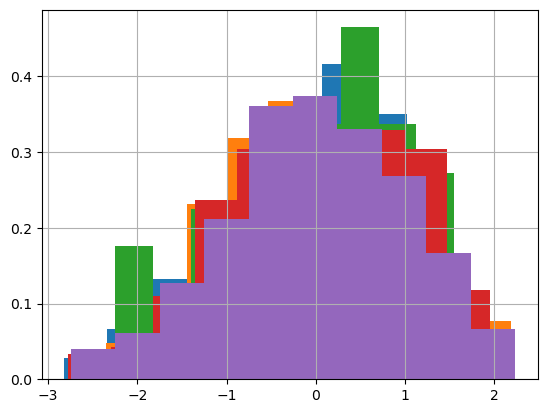

In [27]:
df_temp = df_diag.loc[df_diag["ICD_Code"].isin(results_norm_df.loc[results_norm_df["is_normal"]].head(5)["ICD_Code"])]
df_temp.groupby(["Diagnosis_Description"],observed=True)["Z-score-Age_at_diagnosis"].hist(density=1,) # does overlapping plots - hard to read

#### Onset age with a *skewed* distribution

Diagnosis_Description
Anaemia, unspecified                                                Axes(0.125,0.11;0.775x0.77)
Arthritis, unspecified                                              Axes(0.125,0.11;0.775x0.77)
Haemorrhoids,  unspecified                                          Axes(0.125,0.11;0.775x0.77)
Personal history of long-term (current) use of anticoagulants       Axes(0.125,0.11;0.775x0.77)
Personal history of long-term (current) use of other medicaments    Axes(0.125,0.11;0.775x0.77)
Name: Z-score-Age_at_diagnosis, dtype: object

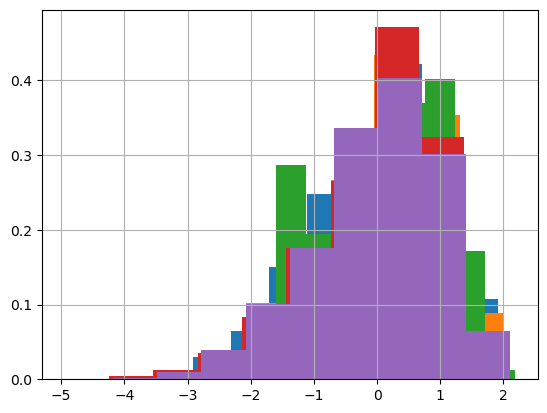

In [28]:
df_temp = df_diag.loc[df_diag["ICD_Code"].isin(results_norm_df.loc[~results_norm_df["is_normal"]].head(5)["ICD_Code"])]
df_temp.groupby(["Diagnosis_Description"],observed=True)["Z-score-Age_at_diagnosis"].hist(density=1,) # does overlapping plots - hard to read

```
'I10':"Essential (primary) hypertension"
'Z86.4': "Personal history of psychoactive substance abuse"
'E78.0': "Pure hypercholesterolaemia"
```

Essential (primary) hypertension
Personal history of psychoactive substance abuse
Pure hypercholesterolaemia


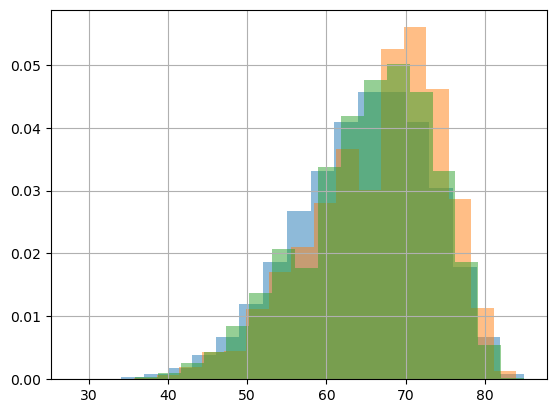

In [29]:
# for d in results_norm_df.head(15)["ICD_Code"]:
for d in ['I10','Z86.4','E78.0']:
    df_temp = df_diag.loc[df_diag["ICD_Code"]==d]
    print(df_temp["Diagnosis_Description"].iloc[0])
    # df_temp["Z-score-Age_at_diagnosis"].hist(density=1, bins=16, stacked=False, alpha=.45)
    df_temp["Age_at_diagnosis"].hist(density=1, bins=19, stacked=False, alpha=.5)
    
    

Personal history of psychoactive substance abuse


<Axes: >

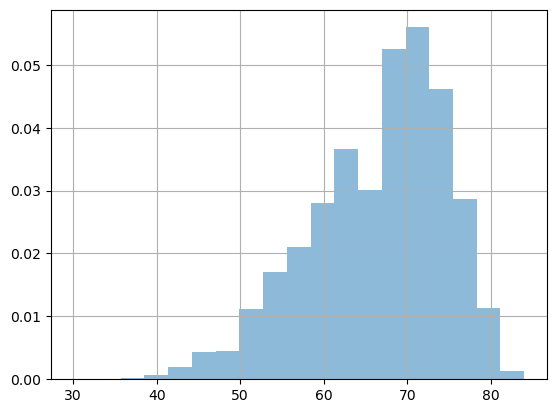

In [30]:
df_temp = df_diag.loc[df_diag["ICD_Code"]=='Z86.4']
print(df_temp["Diagnosis_Description"].iloc[0])
# df_temp["Z-score-Age_at_diagnosis"].hist(density=1, bins=16, stacked=False, alpha=.45)
df_temp["Age_at_diagnosis"].hist(density=1, bins=19, stacked=False, alpha=.5)

In [31]:
# ## cholesterol nmr df - filter by this
# filt_df = df = pd.read_csv("Cholesterol_miki_participant.csv.gz").dropna(thresh=5,axis=0)
# print(filt_df.shape)
# filt_ids = list(filt_df["eid"].unique())
# print(len(filt_ids),"# filt IDs")

In [32]:
# df_diag = df_diag.loc[df_diag['eid'].isin(filt_ids)]
# df_diag.shape[0]

In [33]:
# df_diag = df_diag[['eid', "Year of birth",
#                    'Sex', 'Diagnoses - ICD10']].drop_duplicates()

# df_diag

In [34]:
df_diag.nunique()

eid                         440004
YOB                             37
Sex                              2
ICD_Code                     10151
Diagnosis_Description         8975
Diagnosis Date                9641
Age_at_diagnosis                61
Z-score-Age_at_diagnosis    355705
dtype: int64

In [35]:
df_diag.isna().max()

eid                         False
YOB                         False
Sex                         False
ICD_Code                    False
Diagnosis_Description       False
Diagnosis Date              False
Age_at_diagnosis            False
Z-score-Age_at_diagnosis     True
dtype: bool

In [36]:
# df_diag[df_diag["Diagnoses - ICD10"].str.contains("E78.0",case=False,na=False)]
# df_diag[df_diag["Diagnoses - ICD10"].str.contains("Familial hyper",case=False,na=False)]

In [37]:
# # df = df_diag.head(5000).copy()

# df = df_diag.copy()

In [38]:
df

,eid,Year of birth(participant - p34),Sex,Diagnoses - ICD10,Date of first in-patient diagnosis - ICD10 | Array 0,Date of first in-patient diagnosis - ICD10 | Array 1,Date of first in-patient diagnosis - ICD10 | Array 2,Date of first in-patient diagnosis - ICD10 | Array 3,Date of first in-patient diagnosis - ICD10 | Array 4,Date of first in-patient diagnosis - ICD10 | Array 5,...,Date of first in-patient diagnosis - ICD10 | Array 237,Date of first in-patient diagnosis - ICD10 | Array 238,Date of first in-patient diagnosis - ICD10 | Array 239,Date of first in-patient diagnosis - ICD10 | Array 240,Date of first in-patient diagnosis - ICD10 | Array 241,Date of first in-patient diagnosis - ICD10 | Array 242,Age at menopause (last menstrual period) | Instance 0,Age at menopause (last menstrual period) | Instance 1,Age at menopause (last menstrual period) | Instance 2,Age at menopause (last menstrual period) | Instance 3
0,1000015,1951.0,Female,K21.9 Gastro-oesophageal reflux disease withou...,2013-09-05,2013-11-25,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,51,NaN,NaN,NaN
1,1000027,1939.0,Male,"I25.9 Chronic ischaemic heart disease, unspeci...",2012-11-06,2012-11-06,2012-11-06,2012-11-06,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1000039,1942.0,Female,"B34.9 Viral infection, unspecified|D64.9 Anaem...",2017-02-03,2011-05-26,2021-05-29,2018-02-22,2005-06-20,2008-04-15,...,NaN,NaN,NaN,NaN,NaN,NaN,57,NaN,NaN,NaN
3,1000040,1948.0,Male,D12.3 Transverse colon|D12.7 Rectosigmoid junc...,2021-05-24,2017-04-18,2020-06-15,2020-06-15,2021-04-16,2020-06-15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1000053,1944.0,Female,S22.30 Fracture of rib (closed)|S27.10 Traumat...,2006-09-14,2006-09-14,2006-09-14,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,50,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440012,6026238,1944.0,Male,"C16.9 Stomach, unspecified|D12.0 Caecum|K62.1 ...",2008-04-01,2018-10-15,2011-10-03,2018-10-15,2018-10-15,2008-04-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
440013,6026246,1953.0,Female,D36.1 Peripheral nerves and autonomic nervous ...,2015-02-17,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,52,NaN,52,NaN
440014,6026252,1941.0,Female,"F32.9 Depressive episode, unspecified|H25.9 Se...",2005-12-23,2007-07-04,2013-05-28,2013-05-28,2005-12-23,2011-06-01,...,NaN,NaN,NaN,NaN,NaN,NaN,51,NaN,NaN,NaN
440015,6026289,1959.0,Female,A09.9 Gastroenteritis and colitis of unspecifi...,2017-11-14,2013-02-11,2016-01-14,2013-02-11,2015-09-23,2015-09-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
%%time
## warning: with categoricals gets all combs. And this is a very big, dense matrix (pre filt
print(df_diag["ICD_Code"].nunique())
df_flat = df_diag.groupby(["Diagnosis_Description"]).filter(lambda x: len(x) >= 150).copy()
print(df_flat["ICD_Code"].nunique())
df_flat["ICD_Code"] = df_flat["ICD_Code"].astype(str) +" - "+df_flat['Diagnosis_Description'].astype(str)
df_flat = pd.crosstab(df_flat['eid'], df_flat["ICD_Code"])
df_flat

10151


<timed exec>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


3633
CPU times: user 1min 45s, sys: 44.4 s, total: 2min 29s
Wall time: 2min 48s


ICD_Code,A04.5 - Campylobacter enteritis,A04.7 - Enterocolitis due to Clostridium difficile,A04.8 - Other specified bacterial intestinal infections,A08.1 - Acute gastro-enteropathy due to Norwalk agent,"A08.4 - Viral intestinal infection, unspecified",A09 - Diarrhoea and gastro-enteritis of presumed infectious origin,A09.0 - Other and unspecified gastroenteritis and colitis of infectious origin,A09.9 - Gastroenteritis and colitis of unspecified origin,A40.8 - Other streptococcal septicaemia,A41.0 - Septicaemia due to Staphylococcus aureus,...,Z97.5 - Presence of (intra-uterine) contraceptive device,Z97.8 - Presence of other specified devices,Z98.0 - Intestinal bypass and anastomosis status,Z98.1 - Arthrodesis status,Z98.2 - Presence of cerebrospinal fluid drainage device,Z98.8 - Other specified postsurgical states,Z99.1 - Dependence on respirator,Z99.2 - Dependence on renal dialysis,Z99.3 - Dependence on wheelchair,Z99.8 - Dependence on other enabling machines and devices
eid,,,,,,,,,,,,,,,,,,,,,
1000015,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000027,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000039,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000040,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000053,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6026238,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6026246,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6026252,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
if SAVE_TIDY_OUTPUT_DF:
    # df_flat.reset_index().to_csv("df_diag_icd10_wide.csv",index=False)#.drop(columns="ICD_Code")
    df_flat.reset_index().to_parquet("df_diag_icd10_wide.parquet",index=False)#.drop(columns="ICD_Code")
    # pd.read_parquet("df_diag_icd10_wide.parquet")

In [41]:
# df_diag[['eid',
# 'YOB', 'Sex','ICD_Code']].head(39).pivot_table(index=['eid', 'YOB', 'Sex'], columns='ICD_Code') # , values='score'

* Previous/old code for getting wide feature matrix of diags + filtered

In [42]:
# %%time
# # Re-implementing the process without explicitly using an extra 'index' column

# K_value = 10

# # Start by creating a long format dataframe of diagnoses directly from the original dataframe, preserving the index
# diagnoses_long_df_refined = df['Diagnoses - ICD10'].str.split('|', expand=True).stack().reset_index(level=1, drop=True).to_frame('Diagnosis')
# # # diagnoses_long_df_refined['ICD_code'] = diagnoses_long_df_refined['Diagnosis'].apply(lambda x: x.split(' ')[0])
# diagnoses_long_df_refined['ICD_code'] = diagnoses_long_df_refined['Diagnosis']


# # Count occurrences and filter codes as before
# code_counts_refined = diagnoses_long_df_refined['ICD_code'].value_counts()
# print(len(code_counts_refined),"# all code_counts")
# codes_to_keep_refined = code_counts_refined[code_counts_refined >= K_value].index
# print(len(codes_to_keep_refined),"# codes_to_keep_refined")
# # Filter diagnoses to keep only frequently occurring codes
# filtered_diagnoses_refined = diagnoses_long_df_refined[diagnoses_long_df_refined['ICD_code'].isin(codes_to_keep_refined)]

# # Apply one-hot encoding on the filtered ICD10 codes, grouping by the original index to align with the original dataframe
# one_hot_encoding_refined = pd.get_dummies(filtered_diagnoses_refined['ICD_code'],dummy_na=False).groupby(level=0).max()

# # Merge with the original dataframe excluding the 'Diagnoses - ICD10' column
# optimized_df_without_extra_index = df.drop(columns=['Diagnoses - ICD10']).join(one_hot_encoding_refined)

# optimized_df_without_extra_index.drop(columns=[""],errors="ignore",inplace=True)
# # Verify the transformation by displaying the first few rows
# optimized_df_without_extra_index

# ## the empty "" col is cases with 0 diagnoses = all nans . it is ok ! 